In [ ]:
# SETUP: INSTALLATION & IMPORTS
!pip install transformers datasets evaluate scikit-learn matplotlib accelerate -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gc
import matplotlib.pyplot as plt
from datasets import load_dataset, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    TrainerCallback,
    AutoModel,
    AutoConfig,
    PreTrainedModel
)
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score
from scipy.special import softmax
from sklearn.utils.class_weight import compute_class_weight

# Random Seed for Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

print("Libraries installed and imported.")

print("\n--- Loading and Splitting Data ---")
dataset_name = "atrost/financial_phrasebank"
raw_dataset = load_dataset(dataset_name)
all_data = concatenate_datasets([raw_dataset['train'], raw_dataset['validation'], raw_dataset['test']])

if "label" in all_data.column_names:
    all_data = all_data.rename_column("label", "labels")

# Exact Splits: 64% Train, 16% Val, 20% Test
train_test_split = all_data.train_test_split(test_size=0.2, seed=SEED)
test_dataset = train_test_split['test']
remaining = train_test_split['train']
train_val_split = remaining.train_test_split(test_size=0.2, seed=SEED)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

labels_list = ["negative", "neutral", "positive"]
id2label = {i: l for i, l in enumerate(labels_list)}
label2id = {l: i for i, l in enumerate(labels_list)}

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

# Metric Helper Function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="macro")
    return {"accuracy": acc, "f1_macro": f1}

# Universal Unfreezing Callback (Used across trials)
class UniversalGradualUnfreezing(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        model = kwargs['model']
        train_dataloader = kwargs['train_dataloader']

        # Identify encoder (BERT or RoBERTa)
        if hasattr(model, "roberta"):
            encoder = model.roberta
        elif hasattr(model, "bert"):
            encoder = model.bert
        else:
            # Fallback for custom models where 'roberta' might be a direct attribute
            encoder = model.roberta if hasattr(model, "roberta") else model.bert

        # Freeze encoder
        for param in encoder.parameters():
            param.requires_grad = False

        # Ensure Classifier is unfrozen
        if hasattr(model, "classifier"):
            for param in model.classifier.parameters():
                param.requires_grad = True

        self.num_layers_unfrozen = 0
        self.steps_in_epoch = len(train_dataloader)

    def on_step_end(self, args, state, control, **kwargs):
        if self.steps_in_epoch == 0: return
        unfreeze_step = max(1, int(self.steps_in_epoch / 3))
        target_layers = min(12, int(state.global_step / unfreeze_step))

        if target_layers > self.num_layers_unfrozen:
            model = kwargs['model']
            if hasattr(model, "roberta"):
                encoder = model.roberta
            elif hasattr(model, "bert"):
                encoder = model.bert

            needed = target_layers - self.num_layers_unfrozen
            for _ in range(needed):
                if self.num_layers_unfrozen >= 12: break
                idx = 11 - self.num_layers_unfrozen
                if hasattr(encoder, "encoder"):
                    for param in encoder.encoder.layer[idx].parameters():
                        param.requires_grad = True
                self.num_layers_unfrozen += 1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
Libraries installed and imported.

--- Loading and Splitting Data ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/721 [00:00<?, ?B/s]

data/train-00000-of-00001-138b53eb17a3e8(…):   0%|          | 0.00/268k [00:00<?, ?B/s]

data/validation-00000-of-00001-0876be41e(…):   0%|          | 0.00/68.7k [00:00<?, ?B/s]

data/test-00000-of-00001-41c7ea948573445(…):   0%|          | 0.00/82.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/776 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/970 [00:00<?, ? examples/s]

Train: 3100 | Val: 776 | Test: 970


In [ ]:
# TRIAL 1: Weighted Cross Entropy Loss
print("\n--- TRIAL 1: WEIGHTED LOSS ---")

# Tokenize for BERT
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_bert(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True, max_length=64)

tokenized_train = train_dataset.map(tokenize_bert, batched=True)
tokenized_val = val_dataset.map(tokenize_bert, batched=True)
tokenized_test = test_dataset.map(tokenize_bert, batched=True)

# Calculate Class Weights
train_labels = tokenized_train["labels"]
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)
weights_tensor = torch.FloatTensor(class_weights).to("cuda")
print("Computed Class Weights:", weights_tensor)

# Custom Trainer
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

    def create_optimizer(self):
        opt_model = self.model
        if self.optimizer is None:
            lr = self.args.learning_rate
            weight_decay = self.args.weight_decay
            discrimination_rate = 0.85
            optimizer_grouped_parameters = [
                {"params": [p for n, p in opt_model.bert.named_parameters() if p.requires_grad], "lr": lr * discrimination_rate, "weight_decay": weight_decay},
                {"params": [p for n, p in opt_model.classifier.named_parameters() if p.requires_grad], "lr": lr, "weight_decay": weight_decay},
            ]
            self.optimizer = AdamW(optimizer_grouped_parameters, lr=lr, betas=(self.args.adam_beta1, self.args.adam_beta2), eps=self.args.adam_epsilon)
        return self.optimizer

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3, id2label=id2label, label2id=label2id)

training_args = TrainingArguments(
    output_dir="finbert_weighted_loss",
    learning_rate=2e-5, per_device_train_batch_size=64, per_device_eval_batch_size=64,
    num_train_epochs=6, weight_decay=0.01, eval_strategy="epoch", save_strategy="epoch",
    load_best_model_at_end=True, metric_for_best_model="f1_macro", lr_scheduler_type="linear",
    warmup_ratio=0.2, logging_strategy="epoch", report_to="none"
)

trainer = WeightedLossTrainer(
    model=model, args=training_args, train_dataset=tokenized_train, eval_dataset=tokenized_val,
    tokenizer=tokenizer, compute_metrics=compute_metrics, callbacks=[UniversalGradualUnfreezing()]
)

trainer.train()

print("\n--- Final Evaluation (Trial 1) ---")
preds = trainer.predict(tokenized_test)
y_preds = np.argmax(preds.predictions, axis=-1)
print(classification_report(preds.label_ids, y_preds, target_names=labels_list, digits=4))

# Cleanup
del model, trainer
torch.cuda.empty_cache()
gc.collect()


--- TRIAL 1: WEIGHTED LOSS ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/776 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

Computed Class Weights: tensor([2.7853, 0.5619, 1.1610], device='cuda:0')


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3130692084.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.128300,1.074733,0.237113,0.224486
2,0.979600,0.800435,0.654639,0.626621
3,0.692900,0.501704,0.779639,0.781467
4,0.483200,0.411143,0.800258,0.802144
5,0.390100,0.373155,0.815722,0.820466
6,0.335300,0.364266,0.827320,0.828877



--- Final Evaluation (Trial 1) ---


              precision    recall  f1-score   support

    negative     0.7378    0.9528    0.8316       127
     neutral     0.9294    0.7980    0.8587       594
    positive     0.6959    0.8273    0.7560       249

    accuracy                         0.8258       970
   macro avg     0.7877    0.8593    0.8154       970
weighted avg     0.8444    0.8258    0.8288       970



806

In [ ]:
# TRIAL 2: Consistency Regularization (FinBERT-CR)

print("\n--- TRIAL 2: CONSISTENCY REGULARIZATION ---")

class ConsistencyTrainer(Trainer):
    def __init__(self, *args, alpha=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs1 = model(**inputs)
        logits1 = outputs1.logits
        outputs2 = model(**inputs) # Second pass (different dropout mask)
        logits2 = outputs2.logits

        labels = inputs.get("labels")
        ce_loss = 0.5 * (F.cross_entropy(logits1, labels) + F.cross_entropy(logits2, labels))

        p1 = F.log_softmax(logits1, dim=-1)
        p2 = F.log_softmax(logits2, dim=-1)
        p1_target = F.softmax(logits1, dim=-1)
        p2_target = F.softmax(logits2, dim=-1)

        kl_loss = 0.5 * (F.kl_div(p1, p2_target, reduction="batchmean") + F.kl_div(p2, p1_target, reduction="batchmean"))
        loss = ce_loss + (self.alpha * kl_loss)
        return (loss, outputs1) if return_outputs else loss

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id)

training_args = TrainingArguments(
    output_dir="finbert_consistency_reg",
    learning_rate=2e-5, per_device_train_batch_size=64, per_device_eval_batch_size=64,
    num_train_epochs=6, weight_decay=0.01, eval_strategy="epoch", save_strategy="epoch",
    load_best_model_at_end=True, metric_for_best_model="f1_macro", lr_scheduler_type="linear",
    warmup_ratio=0.2, logging_strategy="epoch", report_to="none"
)

trainer = ConsistencyTrainer(
    alpha=4.0, model=model, args=training_args, train_dataset=tokenized_train,
    eval_dataset=tokenized_val, tokenizer=tokenizer, compute_metrics=compute_metrics,
    callbacks=[UniversalGradualUnfreezing()]
)

trainer.train()

print("\n--- Final Evaluation (Trial 2) ---")
preds = trainer.predict(tokenized_test)
y_preds = np.argmax(preds.predictions, axis=-1)
print(classification_report(preds.label_ids, y_preds, target_names=labels_list, digits=4))

# Cleanup
del model, trainer
torch.cuda.empty_cache()
gc.collect()


--- TRIAL 2: CONSISTENCY REGULARIZATION ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3160458242.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `ConsistencyTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.002700,0.917447,0.574742,0.243317
2,0.825400,0.671163,0.725515,0.658279
3,0.638200,0.492371,0.818299,0.797032
4,0.500900,0.418400,0.849227,0.838552
5,0.429500,0.393285,0.854381,0.845508
6,0.388600,0.383130,0.860825,0.852082



--- Final Evaluation (Trial 2) ---


              precision    recall  f1-score   support

    negative     0.8129    0.8898    0.8496       127
     neutral     0.9033    0.8805    0.8917       594
    positive     0.7738    0.7831    0.7784       249

    accuracy                         0.8567       970
   macro avg     0.8300    0.8511    0.8399       970
weighted avg     0.8582    0.8567    0.8571       970



806


--- TRIAL 3: MULTI-LAYER FUSION IWTH RoBERTa ---


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/776 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-490056814.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.020400,0.949116,0.574742,0.243317
2,0.881800,0.732819,0.645619,0.443197
3,0.489800,0.347286,0.864691,0.855613
4,0.304900,0.349671,0.855670,0.854269
5,0.237900,0.324776,0.868557,0.861670
6,0.184400,0.321023,0.869845,0.864944



--- Final Evaluation (Trial 3) ---


              precision    recall  f1-score   support

    negative     0.8276    0.9449    0.8824       127
     neutral     0.9221    0.8771    0.8991       594
    positive     0.8077    0.8434    0.8251       249

    accuracy                         0.8773       970
   macro avg     0.8525    0.8885    0.8689       970
weighted avg     0.8804    0.8773    0.8779       970



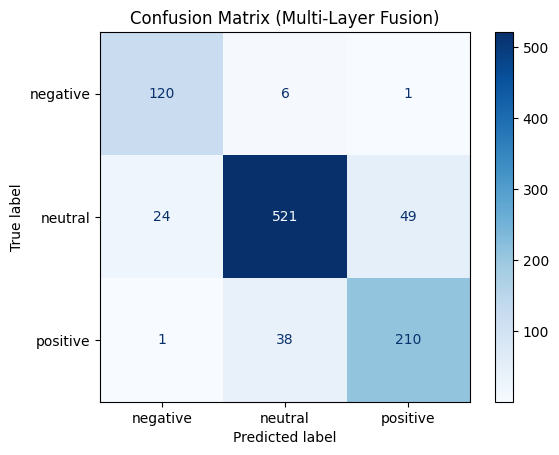


Macro AUROC: 0.9689


In [ ]:
# TRIAL 3: Multi-Layer Fusion Architecture with RoBERTa
print("\n--- TRIAL 3: MULTI-LAYER FUSION IWTH RoBERTa ---")

model_checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_roberta(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True, max_length=64)

tokenized_train = train_dataset.map(tokenize_roberta, batched=True)
tokenized_val = val_dataset.map(tokenize_roberta, batched=True)
tokenized_test = test_dataset.map(tokenize_roberta, batched=True)

class FinancialMultiLayerModel(nn.Module):
    def __init__(self, checkpoint, num_labels):
        super(FinancialMultiLayerModel, self).__init__()
        self.num_labels = num_labels

        # Load Base Model (RoBERTa) with Hidden States
        self.roberta = AutoModel.from_pretrained(checkpoint, config=AutoConfig.from_pretrained(checkpoint, output_hidden_states=True))
        self.dropout = nn.Dropout(0.1)

        # Classifier Head: Hidden Size (768) * 4 Layers
        self.classifier = nn.Linear(768 * 4, num_labels)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.hidden_states

        # Concatenate [CLS] tokens from last 4 layers
        cls_last = hidden_states[-1][:, 0, :]
        cls_2nd = hidden_states[-2][:, 0, :]
        cls_3rd = hidden_states[-3][:, 0, :]
        cls_4th = hidden_states[-4][:, 0, :]

        concat_features = torch.cat((cls_last, cls_2nd, cls_3rd, cls_4th), dim=1)
        x = self.dropout(concat_features)
        logits = self.classifier(x)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

model = FinancialMultiLayerModel(model_checkpoint, num_labels=3)

training_args = TrainingArguments(
    output_dir="finbert_multilayer_fusion",
    learning_rate=2e-5, per_device_train_batch_size=64, per_device_eval_batch_size=64,
    num_train_epochs=6, weight_decay=0.01, eval_strategy="epoch", save_strategy="epoch",
    load_best_model_at_end=True, metric_for_best_model="f1_macro", lr_scheduler_type="linear",
    warmup_ratio=0.2, logging_strategy="epoch", report_to="none"
)

trainer = Trainer(
    model=model, args=training_args, train_dataset=tokenized_train, eval_dataset=tokenized_val,
    tokenizer=tokenizer, compute_metrics=compute_metrics, callbacks=[UniversalGradualUnfreezing()]
)

trainer.train()

print("\n--- Final Evaluation (Trial 3) ---")
preds = trainer.predict(tokenized_test)
y_preds = np.argmax(preds.predictions, axis=-1)
y_true = preds.label_ids
y_scores = softmax(preds.predictions, axis=1)

print(classification_report(y_true, y_preds, target_names=labels_list, digits=4))

# Visualization
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_list)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Multi-Layer Fusion)")
plt.show()

roc = roc_auc_score(y_true, y_scores, multi_class="ovr", average="macro")
print(f"\nMacro AUROC: {roc:.4f}")